In [1]:
from itertools import count
import re
import time
from nltk.corpus import stopwords 
from hlda.sampler import HierarchicalLDA

import pandas as pd
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
import math

### Dataset loading and prepration

In [2]:
#saved the file after cleaning to save multiple experimentation time
abstract=pd.read_csv('Clean/description_clean_file.csv')

In [4]:
index_names = abstract[abstract['genre']=="Entertainment"].index
abstract.drop(index_names, inplace=True)
abstract = abstract.reset_index(drop=True)

In [5]:
index_names = abstract[abstract['genre']=="Tools"].index
abstract.drop(index_names, inplace=True)
abstract = abstract.reset_index(drop=True)

In [6]:
index_names = abstract[abstract['genre']=="Music & Audio"].index
abstract.drop(index_names, inplace=True)
abstract = abstract.reset_index(drop=True)

In [7]:
index_names = abstract[abstract['genre']=="Education"].index
abstract.drop(index_names, inplace=True)
abstract = abstract.reset_index(drop=True)

In [8]:
index_names = abstract[abstract['genre']=="Books & Reference"].index
abstract.drop(index_names, inplace=True)
abstract = abstract.reset_index(drop=True)

In [9]:
abstract = abstract.loc[abstract['clean_description'].str.split().str.len()>11]

abstract.reset_index(drop=True, inplace=True)

In [10]:
abstract.head()

,id,description,genre,genres,clean_description
0,492765,Ù…Ù„Ùƒ Ø§Ù„ØªÙˆØµÙŠÙ„ - Ø¹ÙˆØ¶ Ø£Ø¨Ùˆ Ø´ÙØ©\nÙ„Ø¹Ø¨Ø© Ø³Ø¨Ø§Ù‚ Ø³ÙŠØ§Ø±Ø§Øª Ù„Øª...,Games,"['Games', 'Racing', 'Casual', 'Entertainment']",King of delivery Awad abo shefeh Awad abu s...
1,64074,This crime fighter rescue is all about a super...,Games,"['Games', 'Role Playing', 'Action']",This crime fighter rescue is all about a super...
2,471151,"Build, Customize, Race! Take on the world's be...",Games,"['Games', 'Racing', 'Sports', 'Simulation']","Build, Customize, Race Take on the world s be..."
3,463581,Are you looking for your true digital love? We...,Games,"['Games', 'Entertainment', 'Casual', 'Simulati...",Are you looking for your true digital love? We...
4,188973,Now you can get the chance to become the road ...,Games,"['Games', 'Simulation', 'Entertainment', 'Role...",Now you can get the chance to become the road ...


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
abstract['ABSTRACT']=abstract['clean_description']
vectorizer = CountVectorizer()
document=[]

for i in range(0, len(abstract)):
    document.append(abstract['ABSTRACT'].iloc[i])
vectorizer.fit(document)

CountVectorizer()

In [13]:
len(vectorizer.vocabulary_)

62960

In [14]:
abstract['ABSTRACT']=abstract['clean_description']
#name='hlda_summary_output.txt'

# In[3]:
# stop loss words 
stop = set(stopwords.words('english'))
def clean(doc):
    normalized=''
    # normalize and lemmatize the text
    for word in doc.split():
        if word not in stop:
            normalized = normalized + ' '+ word.lower()
    
    return normalized.strip()


# In[4]:
# clean data stored in a new list
clean_corpus = []
clean_corpus = [clean(doc) for doc in abstract['ABSTRACT']] 


# In[5]:


#Create vocab
vocab = set()
for doc in clean_corpus:
    for w in doc.split():
        if w not in vocab:
            vocab.add(w)


# In[6]:


# For further analysis. term-index
vocab = sorted(list(vocab))
vocab_index = {}
vocab_word_index={}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    vocab_word_index[i] = w


# In[7]:


# Doc-Term matrix
new_corpus = []
for doc in clean_corpus:
    new_doc = []
    for word in doc.split():
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)


# #### HyperParameters
vocab = np.array(vocab)

### Training

#### Hyperparameter

In [15]:
n_samples = 10        # no of iterations for the sampler
alpha = 7          # smoothing over level distributions
gamma = .5           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.9             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 10    # the number of iterations between printing a brief summary of the topics so far
n_words = 100           # the number of most probable words to print for each topic after model estimation
with_weights = True  # whether to print the words with the weights

# #### Train

# In[ ]:
print('training cell with ', alpha)
start = time.time()

training cell with  7


In [16]:
%%capture captured
hlda = HierarchicalLDA(new_corpus, vocab, num_levels=num_levels,eta=eta,alpha=alpha, gamma=gamma)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

In [19]:
res=[]
for i in range(0,len(new_corpus)):
    #print(i, " : ", hlda.document_leaves[i])
    leaf = str(hlda.document_leaves[i])
    topic_id = leaf.split()[0].split("=")[1]
    level = leaf.split()[1].split("=")[1]
    parent = leaf.split()[-1].split("=")[1]
    res.append([int(i),int(topic_id),int(level),int(parent)])


result=pd.DataFrame(res, columns=['doc_id', 'topic_id', 'level','parent'])


num_topic = result['topic_id'].nunique()
end = time.time()
print('time taken for one ', (end-start)/60)
print(num_topic,' number of topics for alpha ', alpha)

time taken for one  46.370981911818184
154  number of topics for alpha  7


In [20]:
#Save
name='CleanDescription_alpha_%s_topic_%s'%(alpha,result['topic_id'].nunique())
with open(name, 'w') as f:
    f.write(captured.stdout)

#### topic_id| candidate_term | level | parent

In [21]:
#open text file in read mode
text_file = open(name, "r")

#read whole file to a string
data = text_file.read()

#close file
text_file.close()
length = len(data.split('\n'))
#length
data_lines = data.split('\n')

In [22]:
topic_data = []
dt_line = data_lines[length-1]
cnt = length-1

while(len(dt_line)==0 or dt_line[0]!='.'): #we need only last iteration
    if(len(dt_line)==0):
        cnt = cnt-1
        dt_line = data_lines[cnt]
        continue    
    topic_id = dt_line.split()[0].split('=')[1]
    level = dt_line.split()[1].split('=')[1]
    terms=[]
    for n in range(3,n_words*2+3,2):
        terms.append(data_lines[cnt].split()[n])
    topic_data.append([int(topic_id),int(level), terms])
    cnt = cnt-1
    dt_line = data_lines[cnt]


In [23]:
tp_data=pd.DataFrame(topic_data, columns=['topic_id','level','topic_terms'])
tp_data.sample(5)

,topic_id,level,topic_terms
137,123,2,"[fowl, dalglish, symmetry., maestro, ios, lega..."
152,15,2,"[yang, dan, untuk, dengan, bisa, kamu, anda, d..."
155,4,2,"[snake,is, snake.this, rotating,, moving,and, ..."
103,137,2,"[grits, consonant, hawk., synthesized, 86, mat..."
58,153,2,"[sights, 3,, slim., mp5,, eyelashes,, beretta,..."


### SOTA

In [24]:
import math
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer

#### number of words in topic

In [25]:
def vector(topic_id,node):
    vectorizer = CountVectorizer()
    document=[]
    if node=='leaf':
        for doc_id in result[result['topic_id']==topic_id]['doc_id']:
               document.append(abstract['ABSTRACT'].iloc[doc_id])
        vectorizer.fit(document)
    elif node=='parent':
        for doc_id in result[result['parent']==topic_id]['doc_id']: #only to change
               document.append(abstract['ABSTRACT'].iloc[doc_id])
        vectorizer.fit(document)
    elif node=='grandparent':
        for doc_id in result['doc_id']:
            document.append(abstract['ABSTRACT'].iloc[doc_id])
        vectorizer.fit(document)
    return vectorizer

In [26]:
leaf_vec = dict()
for t_id in result['topic_id'].unique():    
    try:
        leaf_vec[t_id]=vector(t_id,'leaf')
    except:
        #drop from result
        loc = result[result['topic_id']==t_id].index
        result.drop(loc, inplace=True)
        print(result[result['topic_id']==t_id])

        d_loc = result[result['topic_id']==t_id]['doc_id']
        abstract.drop(d_loc, inplace=True) #not resetting the index

In [28]:
level_one = dict()
for t_id in result['parent'].unique():
    level_one[t_id]=vector(t_id,'parent')

In [29]:
level_zero = dict()
t_id = 0
level_zero[t_id]=vector(t_id,'grandparent')

#### number of doc has term

In [30]:
from collections import defaultdict

In [31]:
def doc_number(topic_id,node):
    documents=[]
    number_word_dict=defaultdict(list)
    
    if node=='leaf':
        for doc_id in result[result['topic_id']==t_id]['doc_id']:
            words=set(abstract['ABSTRACT'].iloc[doc_id].split())
            for wrd in words:
                number_word_dict[wrd].append(doc_id)
    
    elif node=='parent':
        for doc_id in result[result['parent']==t_id]['doc_id']:
            words=set(abstract['ABSTRACT'].iloc[doc_id].split())
            for wrd in words:
                number_word_dict[wrd].append(doc_id)
    
    elif node=='grandparent':
        for doc_id in result['doc_id']:
            words=set(abstract['ABSTRACT'].iloc[doc_id].split())
            for wrd in words:
                number_word_dict[wrd].append(doc_id)
    
    return number_word_dict

In [32]:
leaf_number_doc = dict()
for t_id in result['topic_id'].unique():    
    leaf_number_doc[t_id]=doc_number(t_id,'leaf')

In [33]:
levelONE_number_doc = dict()
for t_id in result['parent'].unique():    
    levelONE_number_doc[t_id]=doc_number(t_id,'parent')

In [34]:
levelZERO_number_doc = dict()
t_id=0
levelZERO_number_doc[t_id]=doc_number(t_id,'grandparent')

### Level 2|| Leaf

In [35]:
def stat_2(topic_j, topic_k, candidate_term): #j should be original and k is child
    a1 = s1_2(topic_k, candidate_term)
    a2 = s2_2(topic_j, candidate_term)
    a3 = a2 #s3_2(topic_j, candidate_term) #Since s3_2 is same as s2_2
    #print(a1,a2,a3)
    return a1*a2*a3

In [36]:
#S1= Idf of term * term frequency in corpus
def s1_2(topic_id, term):
    #number of doc in topic=topic_id; VERIFIED
    doc_in_tid=len(result[result['topic_id']==topic_id])    
    
    #number of doc has term
    if term in leaf_number_doc[topic_id]:
        doc_n = len(leaf_number_doc[topic_id][term])
    else:
        doc_n=1
    
    #number of times term in topic_id
    if term in leaf_vec[topic_id].vocabulary_:
        tf=leaf_vec[topic_id].vocabulary_[term]
    else:
        tf=0
    
    score= math.log(doc_in_tid/doc_n + 1)*tf
    return score

In [37]:
#S2= Parent tf-idf
#Not used TfIdf vectors, as in this, if term in the doc, it is counted only once.
def s2_2(topic_id, term):
    #parent-id
    p_topic_id=result[result['topic_id']==topic_id]['parent'].unique()
    #number of doc in parent_id
    doc_n = len(result[result['parent']==p_topic_id[0]]['doc_id']) #p_topic_id[0]; since only 1 parent possible
    if doc_n == 0:
        doc_n=1
    #number of doc p_topic_id has term
    if term in levelONE_number_doc[p_topic_id[0]]:
        tf=len(levelONE_number_doc[p_topic_id[0]][term])
    else:
        tf=1        
    
    #Log idf in corpus
    score = math.log(doc_n/tf+1)
    return score

### Level 1 || Parent

In [38]:
def stat_1(topic_j, topic_k, candidate_term): #j shuld be original and k is child
    a1 = s1_1(topic_k, candidate_term)
    a2 = s2_1(topic_j, candidate_term)
    a3 = s3_1(topic_j, candidate_term) 
    return a1*a2*a3

In [39]:
def s1_1(topic_id, term):
    #number of doc in topic=topic_id; VERIFIED
    doc_in_tid=len(result[result['topic_id']==topic_id])    
    
    #number of doc has term
    if term in leaf_number_doc[topic_id]:
        doc_n = len(leaf_number_doc[topic_id][term])
    else:
        doc_n = 1
    
    #number of times term in topic_id
    if term in leaf_vec[topic_id].vocabulary_:
        tf=leaf_vec[topic_id].vocabulary_[term]
    else:
        tf=1
    
    score= math.log(doc_in_tid/doc_n + 1)*tf
    return score

In [40]:
def s2_1(topic_id, term):
    #parent-id
    p_topic_id = 0
    #number of doc in parent_id (aka Grandparent)
    doc_n = len(result)
    
    #number of doc p_topic_id has term
    if term in levelZERO_number_doc[p_topic_id]:
        tf=len(levelZERO_number_doc[p_topic_id][term])
    else:
        tf=1        
    
    #Log idf in corpus
    score = math.log(doc_n/tf+1)
    return score    

In [41]:
def s3_1(topic_id, term):
    #direct child
    child = result[result['parent']==topic_id]['topic_id'].unique()
    
    #number of direct child
    number_of_child = len(child)
    
    #number of direct child has term
    child_term_count = 0
    for direct_child in child:
        if term in leaf_number_doc[direct_child]:
            child_term_count+=1    
    if child_term_count == 0:
        child_term_count = 1
    #number of doc in topic_id/parent has term
    if term in levelONE_number_doc[topic_id]:
        term_doc = len(levelONE_number_doc[topic_id][term])
    else:
        term_doc = 1
    
    #number of doc in parent/topic_id
    doc_n = len(result[result['parent']==topic_id]['doc_id'])
    if doc_n == 0:
        doc_n = 1
    
    score = math.log(number_of_child/child_term_count + 1)*math.exp(term_doc/doc_n)
    return score
    

### Level 0 || Grandparent

In [42]:
def stat_0(topic_j, topic_k, candidate_term): #j shuld be original and k is child
    a1 = s1_0(topic_k, candidate_term)
    a2 = s2_0(topic_j, candidate_term)
    a3 = s3_0(topic_j, candidate_term) 
    return a1*a2*a3

In [43]:
def s1_0(topic_id, term):
    #number of doc in topic-id
    doc_in_tid = len(result[result['parent']==topic_id]['doc_id']) #since child of grandparent is parent
    
    #number of doc has term
    if term in levelONE_number_doc[topic_id]:
        doc_n = len(levelONE_number_doc[topic_id][term])
    else:
        doc_n=1
    #number of times term in topic_id
    if term in level_one[topic_id].vocabulary_:
        tf = level_one[topic_id].vocabulary_[term]
    else:
        tf=0
    
    score= math.log(doc_in_tid/doc_n + 1)*tf
    return score

In [44]:
def s2_0(topic_id, term):
    #parent-id
    p_topic_id = 0
    #number of doc in parent_id (GrandParent so all) contains term;
    doc_n = len(result['doc_id'])
    
    #number of doc p_topic_id has term
    if term in levelZERO_number_doc[p_topic_id]:
        tf=len(levelZERO_number_doc[p_topic_id][term])
    else:
        tf=0
        
    if tf==0:
        tf=1
        doc_n=1
    #Log idf in corpus
    score = math.log(doc_n/tf+1)
    return score

In [45]:
def s3_0(topic_id, term):
    #number of direct child
    number_of_child = result['parent'].nunique()
    
    #number of direct child has term
    child_term_count = 0
    for direct_child in result['parent'].unique():
        if term in levelONE_number_doc[direct_child]:
            child_term_count+=1    
    if child_term_count == 0:
        child_term_count = 1
    #number of doc in Grandparent/topic_id has term
    if term in levelZERO_number_doc[0]:
        term_doc = len(levelZERO_number_doc[0][term])
    else:
        term_doc = 1
    
    #number of doc in Grandparent/topic_id
    doc_n = len(result)
    if doc_n==0:
        doc_n=1
    
    score = math.log(number_of_child/child_term_count + 1)*math.exp(term_doc/doc_n)
    return score

In [ ]:
label=[]
for i in range(0,len(tp_data)):
    topic_id = tp_data.iloc[i]['topic_id']
    candidate_terms = tp_data.iloc[i]['topic_terms']
    level = tp_data.iloc[i]['level']
    twl_rank = []
    
    if level == 2: #leaf
        for cnd_term in candidate_terms:
            score=stat_2(topic_id,topic_id,cnd_term)
            #frequency of term in the topic
            if cnd_term in leaf_vec[topic_id].vocabulary_:
                tf = leaf_vec[topic_id].vocabulary_[cnd_term]
            else:
                tf = 1
            twl_rank.append([cnd_term,score*tf])
    
    elif level == 1: #parent        
        for cnd_term in candidate_terms:
            score = 0
            k = result[result['parent']==topic_id]['topic_id']
            for child_id in k:
                #frequency of term in the child_topic
                if cnd_term in leaf_vec[child_id].vocabulary_:
                    tf = leaf_vec[child_id].vocabulary_[cnd_term]
                else:
                    tf = 1
                score += stat_1(topic_id,child_id,cnd_term)*tf
            twl_rank.append([cnd_term,score])
    
    elif level == 0:
        for cnd_term in candidate_terms:
            score = 0
            k = result['parent'].unique()
            for child_id in k:
                #frequency of term in the child_topic
                if cnd_term in level_one[child_id].vocabulary_:
                    tf = level_one[child_id].vocabulary_[cnd_term]
                else:
                    tf = 1
                score += stat_0(topic_id,child_id,cnd_term)*tf
            twl_rank.append([cnd_term,score])            
    
    
    twl_df = pd.DataFrame(twl_rank,columns=['term','score'])
    lbl = twl_df.sort_values('score', ascending=False).iloc[0]['term']
    label.append(lbl)
    if i%50==0:
        print('completed till ', i) #just to check whether code is running.

tp_data['label']=label

In [ ]:
tp_data

## Proposed Methodology

In [ ]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from numpy import dot
from numpy.linalg import norm

### Glove Embedding

In [ ]:
#Pre-trained Glove
emmbed_dict = {}
with open('glove.6B/glove.6B.200d.txt','r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        emmbed_dict[word]=vector

tk = WhitespaceTokenizer()
def doc_arr(doc):
    doc_vec=0
    count=0
    for word in tk.tokenize(doc):
        if word not in stopwords.words('english'):
            count+=1
            try:   #because some words meight not present in the Glove
                doc_vec+=emmbed_dict[wordnet_lemmatizer.lemmatize(word)]
            except:
                doc_vec+=0
    if count==0:
        count=1
    return doc_vec/count
#Cosine Similarity

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

### Keywords

In [ ]:
from keybert import KeyBERT

##### Change this as per the dataset

In [ ]:
result['ABSTRACT'] = abstract['ABSTRACT']
result['label'] = abstract['label']

In [ ]:
result.sample(5)

In [ ]:
###################### Candidate Generation ########################################
####################################################################################
kw_model = KeyBERT("all-MiniLM-L6-v2")
tp_data['uni_labelss_brt'] = ['label']*len(tp_data)

for i in range(0,len(tp_data)):
    topic_id = tp_data.iloc[i]['topic_id']
    candidate_terms = tp_data.iloc[i]['topic_terms']
    level = tp_data.iloc[i]['level']
    
    corpus=''
    if level == 2:
        for abstr in result[result['topic_id']==topic_id]['ABSTRACT']:
            corpus=corpus+'\n'+abstr
    elif level == 1:
        for abstr in result[result['parent']==topic_id]['ABSTRACT']:
            corpus=corpus+'\n'+abstr
    elif level == 0:
        for abstr in result['ABSTRACT']:
            corpus=corpus+'\n'+abstr

    #collecting all the docs corresponding the topic   
    key=[]
    key = kw_model.extract_keywords(corpus, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=100, use_mmr=True)
    #key carries all the keywords in the respective corpus
    lbl=[]
    semaphore=0

    #for seaching topic of the document not documents belonging to the topic.
    wrd_keys=[]
    for keys in key:
        wrd_keys.append(keys[0])

    for wrds in candidate_terms:
        if wrds in wrd_keys:
            lbl.append(wrds)
            semaphore=1    

    if semaphore==0:
        lbl.append('SpamNoMatch')

    #storing all the keywords   
    for ids in tp_data[tp_data['topic_id']==topic_id].index:
        #tp_data.at[ids,'uni_label_brt']=lbl[0]
        tp_data.at[ids,'uni_labelss_brt']=tuple(lbl) #we can use tuple, however str is better
        if tp_data.at[ids,'topic_id']!=topic_id:
            print('alert. Topic id mismatch')
    
    if len(tp_data[tp_data['uni_labelss_brt']=='spamnomatch'])>0:
        print('No Intersection among keyword and topic terms in',len(tp_data[tp_data['uni_label_brt']=='SpamNoMatch']),'of', name)
    

In [ ]:
################### Candidate Ranking ##############################
###################################################################
candidate_label_df=[]
candidate_label_df=pd.DataFrame(columns=['candidate','method_similarity','topic_id','domain_sim'])
final_label=[]

wordnet_lemmatizer = WordNetLemmatizer()
for i in range(0,len(tp_data)):
    topic_id = tp_data.iloc[i]['topic_id']
    candidate_terms = tp_data.iloc[i]['topic_terms']
    level = tp_data.iloc[i]['level']
    sota_label = tp_data.iloc[i]['label'] #later planning to rename it sota_lable
    
    corpus=''
    if level == 2:
        corpus = list(result[result['topic_id']==topic_id]['ABSTRACT'])
        domain_labels = result[result['topic_id']==topic_id]['label'].unique() #need further
    elif level == 1:
        corpus = list(result[result['parent']==topic_id]['ABSTRACT'])
        domain_labels = result[result['parent']==topic_id]['label'].unique()
    elif level == 0:
        corpus = list(result['ABSTRACT'])
        domain_labels = result['label'].unique()
                             

    corpus_glove=0
    for doc in corpus:
        corpus_glove+=doc_arr(doc)
    corpus_glove=corpus_glove/len(corpus)   

    for k in tp_data[tp_data['topic_id']==topic_id]['uni_labelss_brt']:
        label_ranking=[]
        for kk in tk.tokenize(str(k)):
            try:
                sim=cos_sim(corpus_glove,emmbed_dict[wordnet_lemmatizer.lemmatize(re.sub('[^a-zA-Z]','',kk).lower())])
                label_ranking.append([wordnet_lemmatizer.lemmatize(re.sub('[^a-zA-Z]','',kk).lower()),sim])
            except:
                sim=0
                label_ranking.append([wordnet_lemmatizer.lemmatize(re.sub('[^a-zA-Z]','',kk).lower()),sim])            
        
    label_ranked = pd.DataFrame(label_ranking, columns=['label','similarity_score'])
    #Sota similarity
    try:
        sota_sim = cos_sim(corpus_glove,emmbed_dict[wordnet_lemmatizer.lemmatize(re.sub('[^a-zA-Z]','',sota_label).lower())])
    except:
        sota_sim = 0
    
    #Gold Similarity
    #domain_labels = result[result['topic_id']==topic_id]['genre'].unique()
    domain_sim=0
    for j in range(0,len(domain_labels)):
        domain_sim+=cos_sim(corpus_glove,emmbed_dict[wordnet_lemmatizer.lemmatize(re.sub('[^a-zA-Z]','',domain_labels[j]).lower())])
    
    domain_sim=domain_sim/len(domain_labels) #avg nymber of domains it belongs    

    final_label.append([topic_id,label_ranked.sort_values('similarity_score', ascending=False).iloc[0]['label'],label_ranked.sort_values('similarity_score', ascending=False).iloc[0]['similarity_score'], tuple(domain_labels),domain_sim,sota_label,sota_sim])
   
   

In [ ]:
final = pd.DataFrame(final_label,columns=['topic_id','method_label','method_sim','dataset_label','dataset_label_score','sota_label','sota_sim'])

In [ ]:
final['level']=tp_data['level']
final

In [ ]:
name='FinalOutputCleanDescription_alpha_%s.csv'%(alpha)
final.to_csv(name,index=False)

### Analysis

In [1]:
import pandas as pd

In [4]:
final=pd.read_csv('FinalOutputCleanDescription_alpha_7.csv')

final.rename(columns={'method_sim':'Proposed Methodology Similarity','dataset_label_score':'Dataset Label Similarity', 'sota_sim':'TWL Label Similarity'}, inplace=True)

In [5]:
a=final.sort_values(by='topic_id')

a.reset_index(inplace=True)
a.head()

,index,topic_id,method_label,Proposed Methodology Similarity,dataset_label,Dataset Label Similarity,sota_label,TWL Label Similarity,level
0,213,0,label,0.379318,"('games',)",0.675881,slots,0.351633,0
1,212,1,unlock,0.212266,"('games',)",0.675797,sniper,0.184733,1
2,211,2,spamnomatch,0.000000,"('games',)",0.676630,virtual,0.461565,2
3,165,3,xx,0.027793,"('games',)",0.662378,qq,-0.058607,1
4,164,4,figure,0.517497,"('games',)",0.657969,written,0.501156,2


In [8]:
df=pd.DataFrame()

metho=[]
data_la=[]
twl_lab=[]
topic = []

In [9]:
start=0
#bucket size depends upon number of topics
bucket=len(a)//6-1
for i in range(0,5):
    end=start+bucket
    metho.append(sum(a['Proposed Methodology Similarity'][start:end])/bucket)
    data_la.append(sum(a['Dataset Label Similarity'][start:end])/bucket)
    twl_lab.append(sum(a['TWL Label Similarity'][start:end])/bucket)
    topic.append('Topic%s-Topic%s'%(start,end-1))
    start = end

bucket = len(a)-start    
end=start+bucket
metho.append(sum(a['Proposed Methodology Similarity'][start:end])/bucket)
data_la.append(sum(a['Dataset Label Similarity'][start:end])/bucket)
twl_lab.append(sum(a['TWL Label Similarity'][start:end])/bucket)
topic.append('Topic%s-Topic%s'%(start,end-1))
start = end


if(start==len(a)):
    print(start)

214


In [10]:
df['Topics']=topic
df['Dataset Label Similarity'] = data_la
df['Proposed Methodology Similarity'] = metho
df['TWL Label Similarity'] = twl_lab
#df

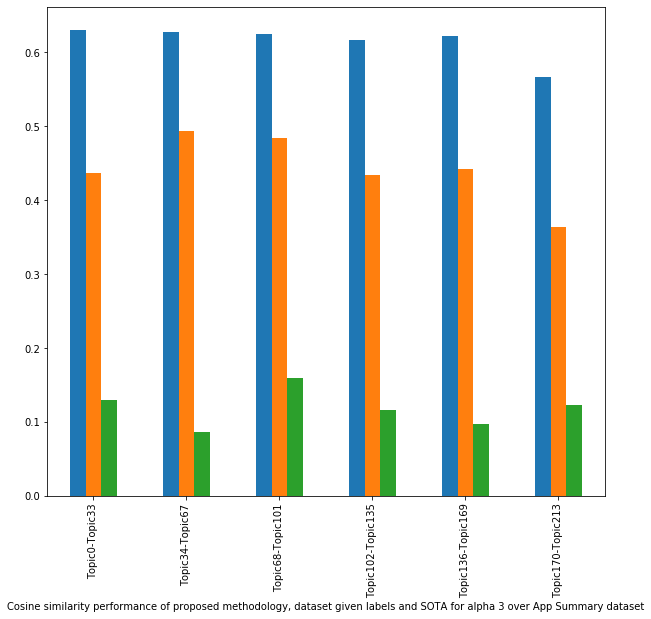

In [12]:
#import matplotlib.pyplot as plt
fig = df.plot(x='Topics',y=['Dataset Label Similarity','Proposed Methodology Similarity','TWL Label Similarity'], kind='bar',figsize=(10,9), xlabel="Cosine similarity performance of proposed methodology, dataset given labels and SOTA for alpha 3 over App Summary dataset", legend=False)